In [14]:
import importlib
import models
importlib.reload(models)

<module 'models' from 'c:\\Users\\louis\\Desktop\\stage\\models.py'>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os
from tqdm import tqdm
from dataset import get_dataloader, plot_statistical_analysis
from torch.utils.data import Subset
import random
from models import load_model_squeezenet, load_model_resnet_18
from performance import plot_full_evaluation_dashboard
from inference import inference, inference_df

import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

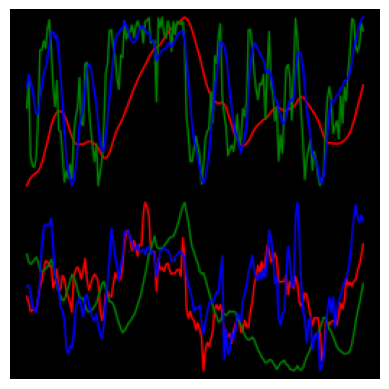

In [3]:
img = mpimg.imread('data\\BIIB_0.png')
plt.imshow(img)
plt.axis('off')  # Hide axes
plt.show()

In [17]:
TRAIN_DIR = "data/"
TEST_DIR = "test/"
TEST_SYNTH_DIR = 'test_synth/'

LABELS_DIR = "labels"
TRAIN_LABEL_FILE = "train_labels.json"
TEST_LABEL_FILE = "test_labels.json"
TEST_SYNTH_LABEL_FILE = "test_synth_labels.json"
TRAIN_LABEL_PATH = os.path.join(LABELS_DIR, TRAIN_LABEL_FILE)
TEST_LABEL_PATH = os.path.join(LABELS_DIR, TEST_LABEL_FILE)
TEST_SYNTH_LABEL_PATH = os.path.join(LABELS_DIR, TEST_SYNTH_LABEL_FILE)

TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 1


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

MODEL_DIR = 'model'
MODEL_NAME = 'resnet_multilabel2'
MODEL_FILE = MODEL_NAME + '.pth'
MODEL_PATH = os.path.join(MODEL_DIR, MODEL_FILE)

PERF_DIR = 'performances'
PERF_FILE = MODEL_NAME + '.png'
PERF_PATH = os.path.join(PERF_DIR, PERF_FILE)

LOSS_FILE = MODEL_NAME + '_loss.png'
LOSS_PATH = os.path.join(PERF_DIR, LOSS_FILE)

INDICS = ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']

In [6]:
train_loader, train_dataset = get_dataloader(TRAIN_DIR, TRAIN_LABEL_PATH, TRAIN_BATCH_SIZE)

test_loader, test_dataset = get_dataloader(TEST_DIR, TEST_LABEL_PATH, TEST_BATCH_SIZE, shuffle = False)

test_synth_loader, test_synth_dataset = get_dataloader(TEST_SYNTH_DIR, TEST_SYNTH_LABEL_PATH, TEST_BATCH_SIZE, shuffle = False)

# Create a smaller test subset
subset_size = 2500
assert subset_size <= len(test_dataset), "Subset size exceeds size of test dataset"

# Random sample without replacement
random.seed(42)
indices = random.sample(range(len(test_dataset)), subset_size)

# Wrap in Subset and new DataLoader
small_test_dataset = Subset(test_dataset, indices)
small_test_loader = DataLoader(small_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)


indices = random.sample(range(len(test_synth_dataset)), subset_size)


# Wrap in Subset and new DataLoader
small_synth_test_dataset = Subset(test_synth_dataset, indices)
small_synth_test_loader = DataLoader(small_synth_test_dataset, batch_size=TEST_BATCH_SIZE, shuffle=False)


📊 Train - Statistical Label Analysis


100%|██████████| 5124/5124 [01:35<00:00, 53.52it/s]


Total samples: 5124


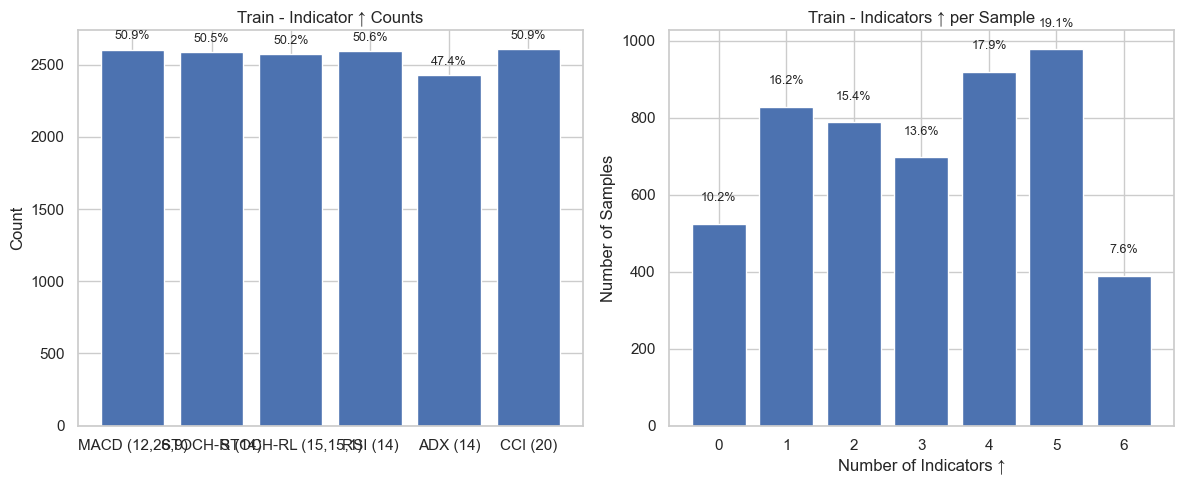

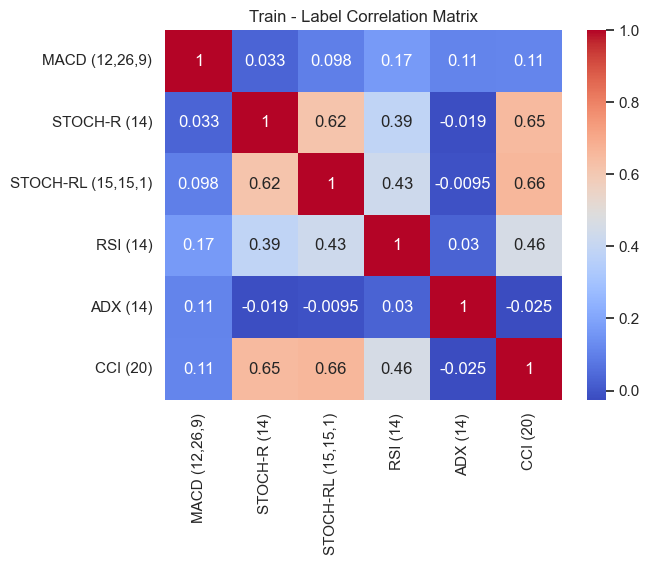


📊 Small Test - Statistical Label Analysis


100%|██████████| 2500/2500 [00:45<00:00, 54.62it/s]


Total samples: 2500


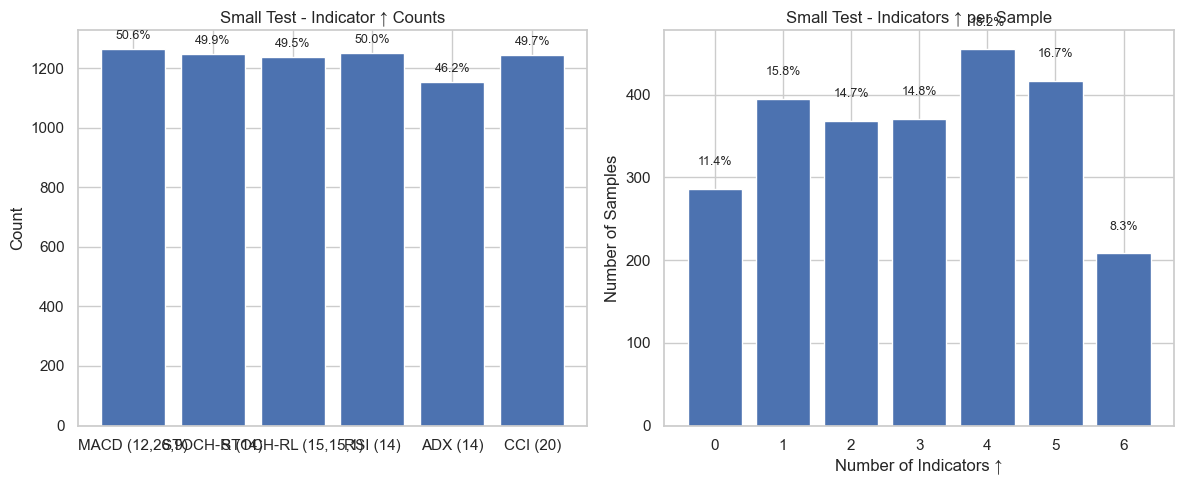

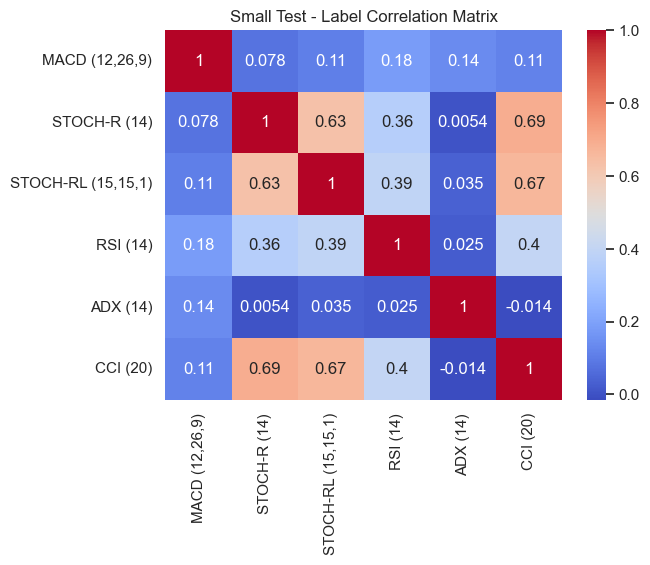


📊 Small Test Synth - Statistical Label Analysis


100%|██████████| 2500/2500 [00:42<00:00, 58.88it/s]


Total samples: 2500


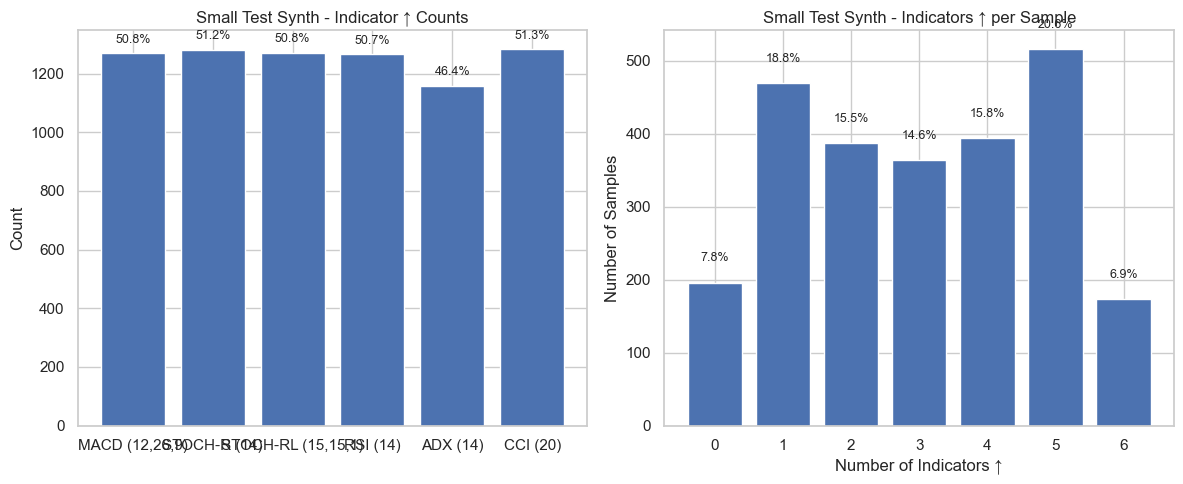

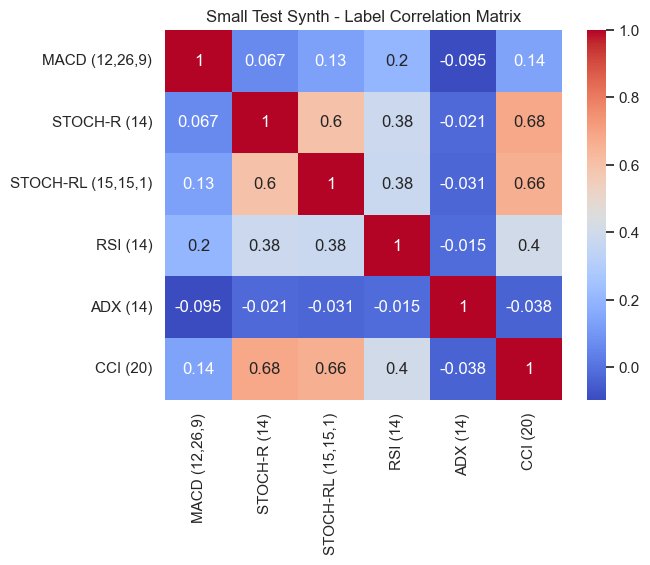

In [5]:
plot_statistical_analysis(train_dataset, INDICS, "Train")
plot_statistical_analysis(small_test_dataset, INDICS, "Small Test")
plot_statistical_analysis(small_synth_test_dataset, INDICS, "Small Test Synth")

c:\Users\louis\Desktop\stage\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\louis\Desktop\stage\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 2500/2500 [02:27<00:00, 16.96it/s]
c:\Users\louis\Desktop\stage\performance.py:224: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = te

Saved to model\resnet_multilabel2.png


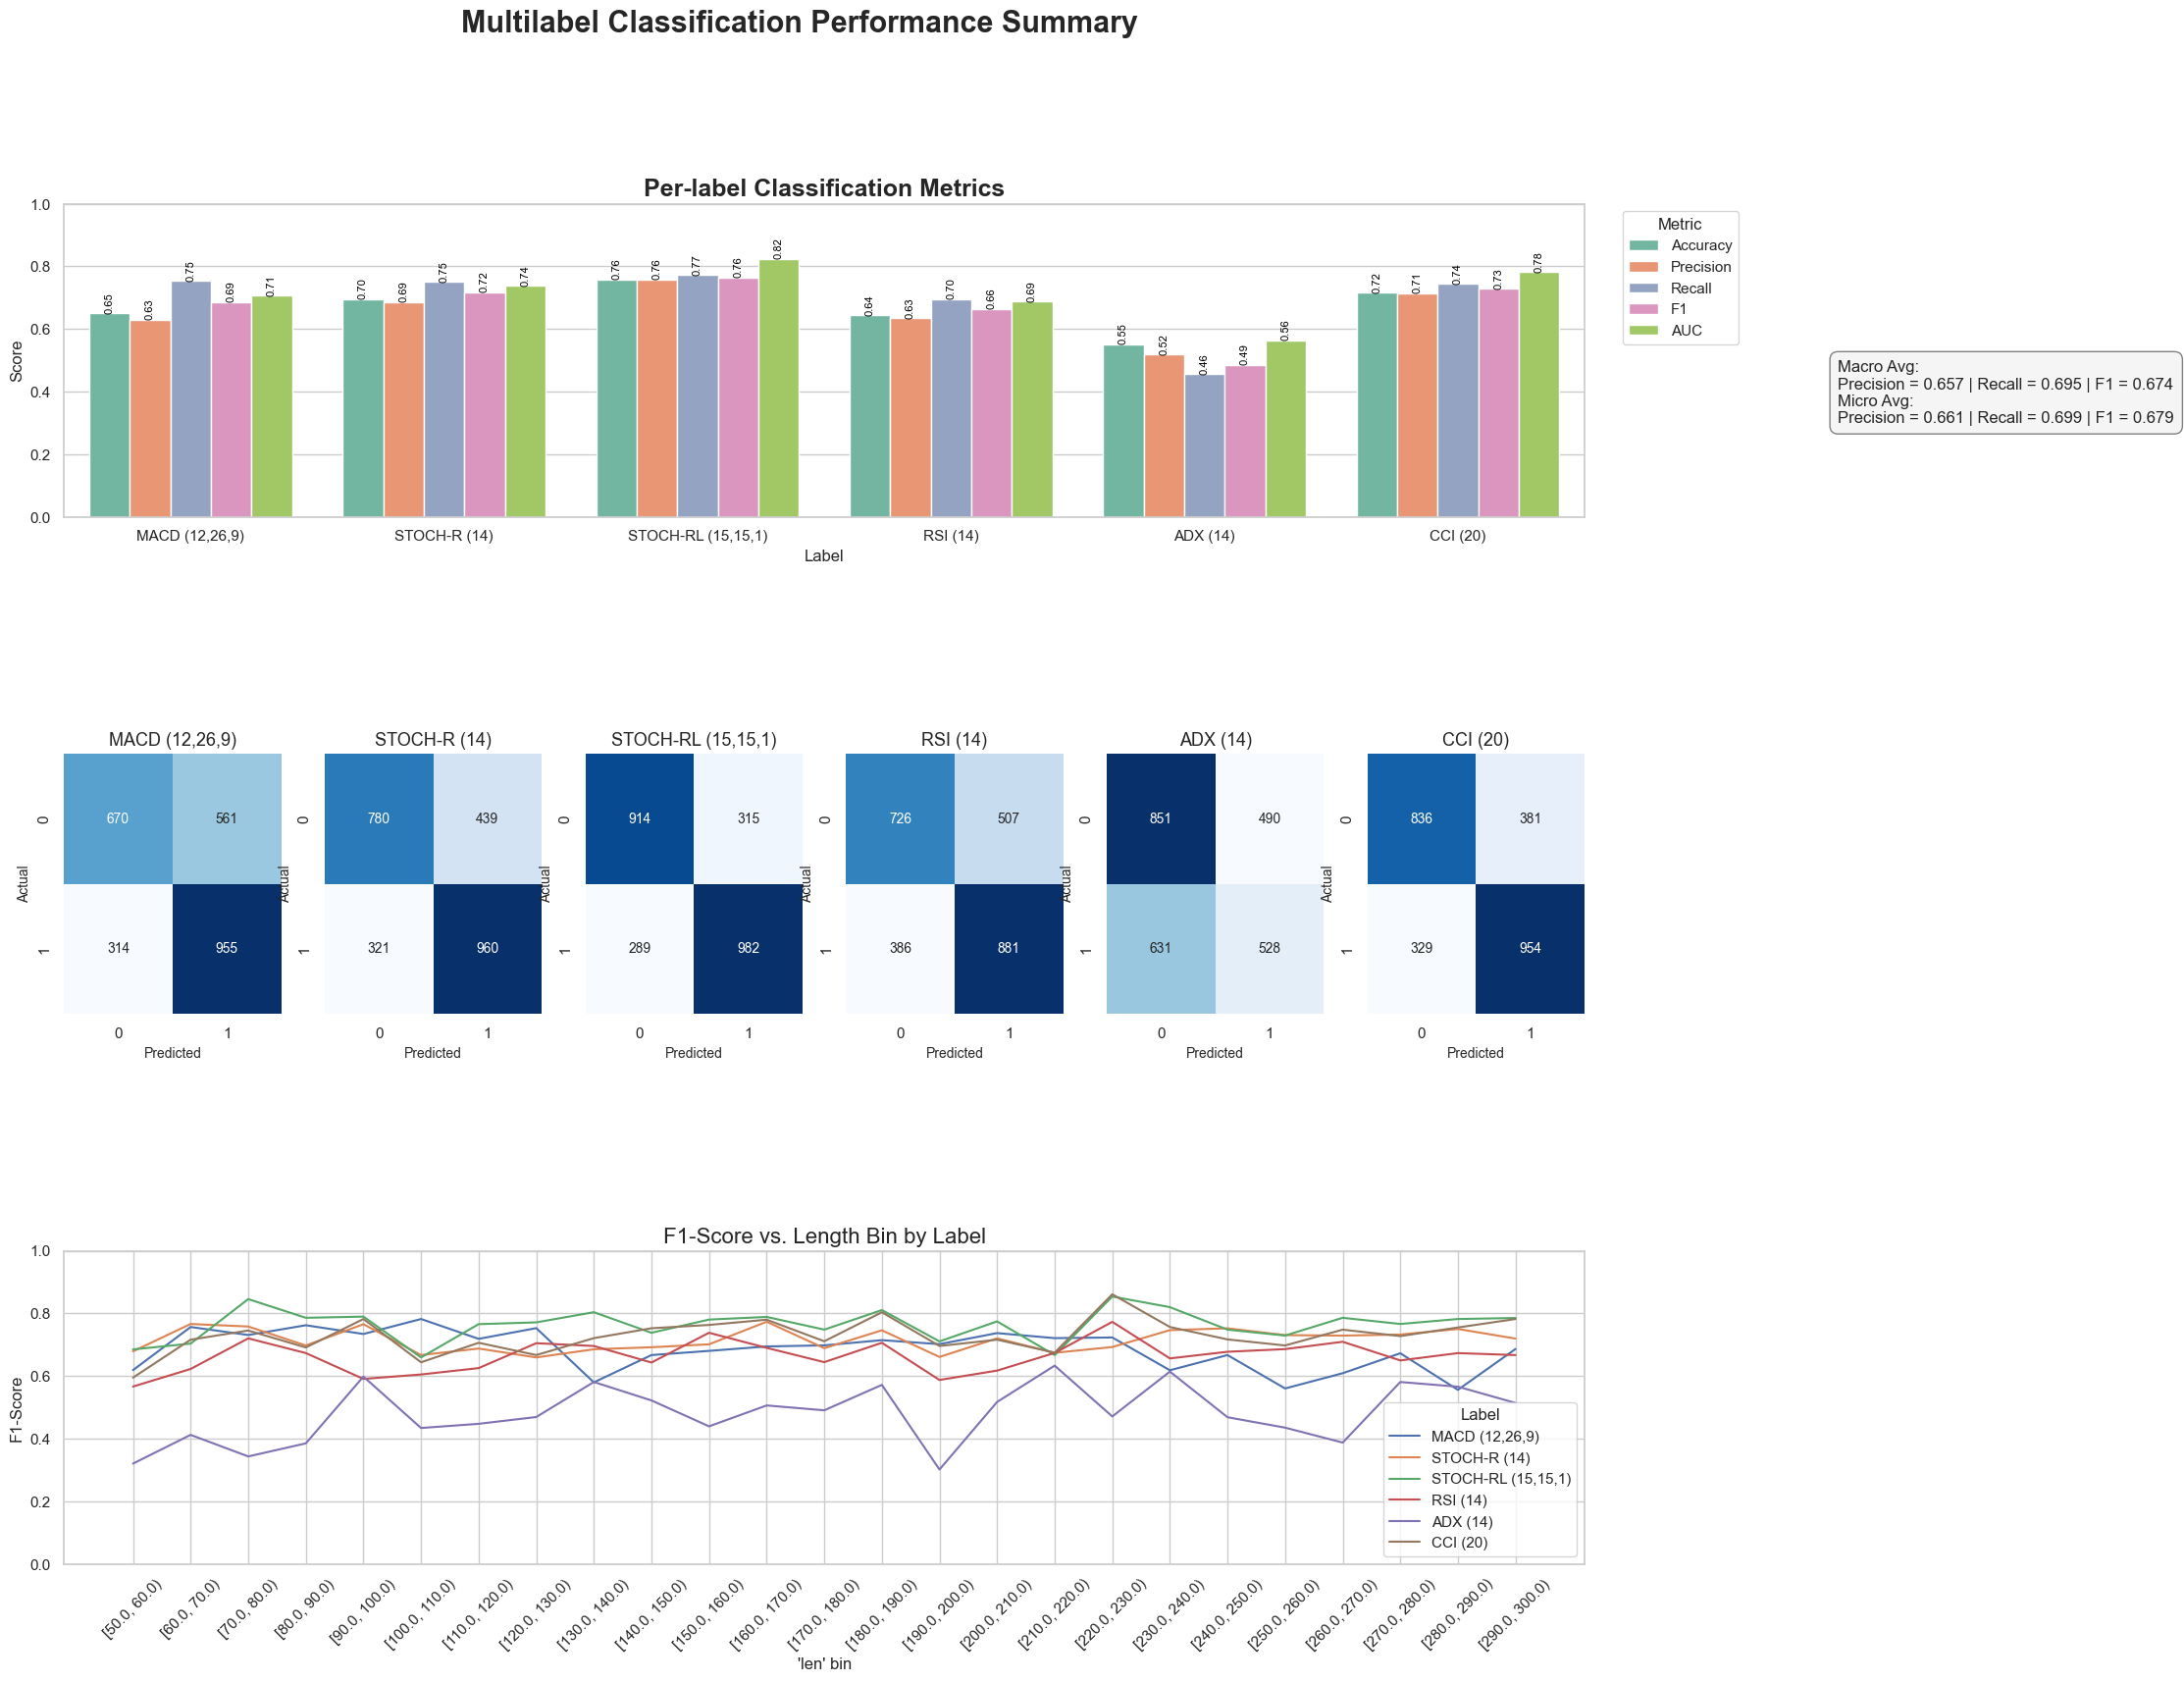

In [16]:
indics = ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']


model = load_model_resnet_18(MODEL_PATH, DEVICE)
all_labels, all_preds, all_probs, _, all_lens, _ = inference (model, small_synth_test_loader, INDICS, DEVICE)

plot_full_evaluation_dashboard(all_labels, all_preds, all_probs, all_lens, indics, save_path = PERF_PATH)

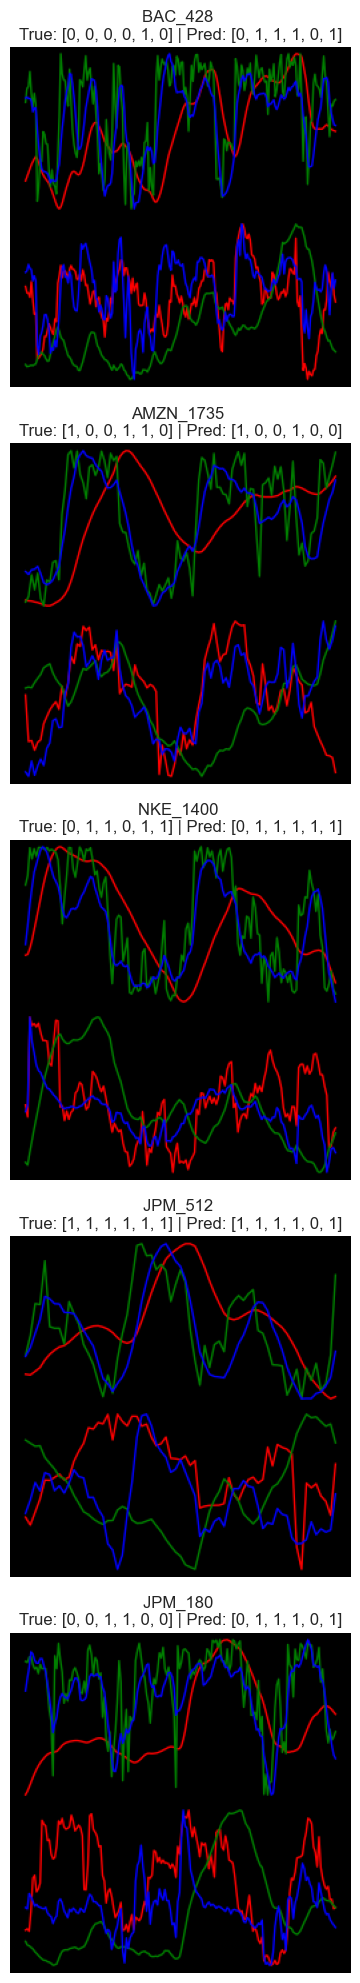

In [44]:
def show_predictions(dataset, y_true, y_pred, num_samples=5):
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 4 * num_samples), squeeze=False)

    for i in range(num_samples):
        img, _, _, png_file = dataset[i]
        img_disp = img.permute(1, 2, 0).numpy()  # CHW -> HWC
        img_disp = (img_disp * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]  # denormalize
        img_disp = np.clip(img_disp, 0, 1)

        pred = y_pred[i]
        true = y_true[i]

        title = png_file.split('.')[0]
        ax = axes[i, 0]
        ax.imshow(img_disp)
        ax.axis('off')
        ax.set_title(f"{title} \nTrue: {true.tolist()} | Pred: {pred.tolist()}", fontsize=12)

    plt.subplots_adjust(hspace=0.4)
    plt.tight_layout()
    plt.show()


# Visualize first few predictions
show_predictions(small_test_dataset, all_labels.astype(int), all_preds.astype(int), num_samples=5)


## ResNet 1

In [ ]:

EPOCHS = 4
LR = 1e-4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 4. Load ResNet and modify last layer
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 6),
    nn.Sigmoid()
)
model = model.to(DEVICE)

# 5. Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

# 6. Training loop
for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0

    for images, labels, _, _ in tqdm(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch {epoch+1}/{EPOCHS}, Loss: {epoch_loss:.4f}")

# 7. Save model
torch.save(model.state_dict(), "model\\resnet_multilabel2.pth")
print("Model saved as resnet_multilabel2.pth")


## ResNet 2

c:\Users\louis\Desktop\stage\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\louis\Desktop\stage\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
161it [05:25,  2.02s/it]


Epoch 1/20, Train Loss: 0.7485, Test Loss: 1864.3492
Model improved and saved.


161it [04:42,  1.75s/it]


Epoch 2/20, Train Loss: 0.7327, Test Loss: 1841.6600
Model improved and saved.


161it [03:27,  1.29s/it]


Epoch 3/20, Train Loss: 0.7187, Test Loss: 1804.7354
Model improved and saved.


161it [03:24,  1.27s/it]


Epoch 4/20, Train Loss: 0.7046, Test Loss: 1780.6556
Model improved and saved.


161it [03:24,  1.27s/it]


Epoch 5/20, Train Loss: 0.6898, Test Loss: 1752.6607
Model improved and saved.


161it [03:25,  1.28s/it]


Epoch 6/20, Train Loss: 0.6751, Test Loss: 1719.5482
Model improved and saved.


161it [03:29,  1.30s/it]


Epoch 7/20, Train Loss: 0.6606, Test Loss: 1681.9142
Model improved and saved.


161it [03:34,  1.33s/it]


Epoch 8/20, Train Loss: 0.6458, Test Loss: 1653.5332
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 9/20, Train Loss: 0.6316, Test Loss: 1621.2683
Model improved and saved.


161it [03:30,  1.30s/it]


Epoch 10/20, Train Loss: 0.6190, Test Loss: 1596.5825
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 11/20, Train Loss: 0.6083, Test Loss: 1578.1904
Model improved and saved.


161it [03:32,  1.32s/it]


Epoch 12/20, Train Loss: 0.5988, Test Loss: 1560.6595
Model improved and saved.


161it [03:33,  1.32s/it]


Epoch 13/20, Train Loss: 0.5902, Test Loss: 1540.7790
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 14/20, Train Loss: 0.5814, Test Loss: 1529.2539
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 15/20, Train Loss: 0.5751, Test Loss: 1519.9218
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 16/20, Train Loss: 0.5678, Test Loss: 1509.6003
Model improved and saved.


161it [03:31,  1.31s/it]


Epoch 17/20, Train Loss: 0.5609, Test Loss: 1505.9380
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 18/20, Train Loss: 0.5558, Test Loss: 1496.3650
Model improved and saved.


161it [03:30,  1.31s/it]


Epoch 19/20, Train Loss: 0.5503, Test Loss: 1489.8039
Model improved and saved.


161it [03:33,  1.33s/it]


Epoch 20/20, Train Loss: 0.5453, Test Loss: 1486.3238
Model improved and saved.
Model saved as resnet_multilabel2.pth


ValueError: x and y must have same first dimension, but have shapes (0,) and (20,)

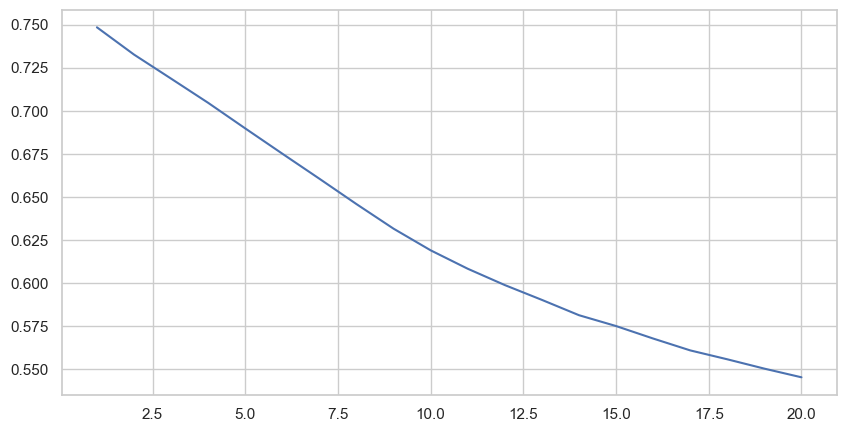

In [ ]:
EPOCHS = 20
LR = 1e-6
PATIENCE = 3  # Stop if no improvement after 2 epochs

train_losses = []
test_losses = []
epoch_train_losses =[]
epoch_test_losses =[]


# 4. Load ResNet and modify last layer
model = models.resnet18(pretrained=True)
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 6),
    nn.Sigmoid()
)
model = model.to(DEVICE)

# 5. Training setup
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

for epoch in range(EPOCHS):
    if early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

    # Training
    model.train()
    running_loss = 0.0

    for i, (images, labels, *_) in tqdm(enumerate(train_loader)):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        '''if i%20 == 19 :
            train_loss = running_loss / (i*TRAIN_BATCH_SIZE)
            train_losses.append(train_loss)
            
            model.eval()
            test_loss = 0.0
            with torch.no_grad():
                for images, labels, _, _ in small_test_loader:
                    images, labels = images.to(DEVICE), labels.to(DEVICE)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item() * images.size(0)
            test_loss = test_loss / len(small_test_loader.dataset)
            test_losses.append(test_loss)
            
            tqdm.write(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

            model.train()'''

    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_losses.append(epoch_train_loss)
    
    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels, *_ in small_test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

    epoch_test_loss = test_loss / len(small_test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {test_loss:.4f}")

    # Early stopping check
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), MODEL_PATH)
        print("Model improved and saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            early_stop = True

torch.save(model.state_dict(), "resnet_multilabel2.pth")
print("Model saved as resnet_multilabel2.pth")


# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), epoch_train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig(LOSS_PATH)
plt.show()

print(f"Loss curve saved as {LOSS_PATH}")

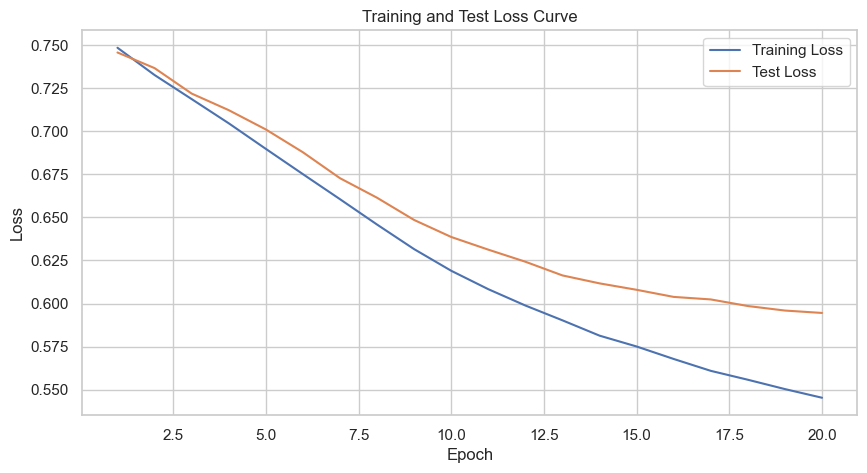

Loss curve saved as loss_curve.png


In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, EPOCHS + 1), epoch_train_losses, label='Training Loss')
plt.plot(range(1, EPOCHS + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

print("Loss curve saved as loss_curve.png")

## SqueezeNet 1

c:\Users\louis\Desktop\stage\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\louis\Desktop\stage\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_1_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_1_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 161/161 [03:28<00:00,  1.29s/it]


Epoch 1/50, Train Loss: 0.7596, Test Loss: 0.6944
Model improved and saved.


100%|██████████| 161/161 [02:07<00:00,  1.27it/s]


Epoch 2/50, Train Loss: 0.6965, Test Loss: 0.6932
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 3/50, Train Loss: 0.6941, Test Loss: 0.6930
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 4/50, Train Loss: 0.6935, Test Loss: 0.6930
Model improved and saved.


100%|██████████| 161/161 [02:06<00:00,  1.28it/s]


Epoch 5/50, Train Loss: 0.6932, Test Loss: 0.6930
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 6/50, Train Loss: 0.6929, Test Loss: 0.6929
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 7/50, Train Loss: 0.6926, Test Loss: 0.6924
Model improved and saved.


100%|██████████| 161/161 [02:06<00:00,  1.28it/s]


Epoch 8/50, Train Loss: 0.6917, Test Loss: 0.6915
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 9/50, Train Loss: 0.6906, Test Loss: 0.6907
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 10/50, Train Loss: 0.6881, Test Loss: 0.6847
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 11/50, Train Loss: 0.6753, Test Loss: 0.6626
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 12/50, Train Loss: 0.6611, Test Loss: 0.6551
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.29it/s]


Epoch 13/50, Train Loss: 0.6538, Test Loss: 0.6535
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 14/50, Train Loss: 0.6498, Test Loss: 0.6500
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 15/50, Train Loss: 0.6474, Test Loss: 0.6482
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.29it/s]


Epoch 16/50, Train Loss: 0.6451, Test Loss: 0.6474
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 17/50, Train Loss: 0.6435, Test Loss: 0.6468
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 18/50, Train Loss: 0.6413, Test Loss: 0.6447
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 19/50, Train Loss: 0.6398, Test Loss: 0.6443
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 20/50, Train Loss: 0.6388, Test Loss: 0.6472


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 21/50, Train Loss: 0.6374, Test Loss: 0.6432
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 22/50, Train Loss: 0.6357, Test Loss: 0.6426
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 23/50, Train Loss: 0.6351, Test Loss: 0.6427


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 24/50, Train Loss: 0.6334, Test Loss: 0.6415
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 25/50, Train Loss: 0.6328, Test Loss: 0.6423


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 26/50, Train Loss: 0.6317, Test Loss: 0.6406
Model improved and saved.


100%|██████████| 161/161 [02:06<00:00,  1.27it/s]


Epoch 27/50, Train Loss: 0.6301, Test Loss: 0.6405
Model improved and saved.


100%|██████████| 161/161 [02:10<00:00,  1.23it/s]


Epoch 28/50, Train Loss: 0.6302, Test Loss: 0.6401
Model improved and saved.


100%|██████████| 161/161 [02:14<00:00,  1.20it/s]


Epoch 29/50, Train Loss: 0.6278, Test Loss: 0.6397
Model improved and saved.


100%|██████████| 161/161 [02:12<00:00,  1.22it/s]


Epoch 30/50, Train Loss: 0.6264, Test Loss: 0.6400


100%|██████████| 161/161 [02:09<00:00,  1.25it/s]


Epoch 31/50, Train Loss: 0.6255, Test Loss: 0.6390
Model improved and saved.


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 32/50, Train Loss: 0.6235, Test Loss: 0.6388
Model improved and saved.


100%|██████████| 161/161 [02:06<00:00,  1.28it/s]


Epoch 33/50, Train Loss: 0.6221, Test Loss: 0.6388
Model improved and saved.


100%|██████████| 161/161 [02:05<00:00,  1.28it/s]


Epoch 34/50, Train Loss: 0.6225, Test Loss: 0.6382
Model improved and saved.


100%|██████████| 161/161 [02:08<00:00,  1.25it/s]


Epoch 35/50, Train Loss: 0.6202, Test Loss: 0.6380
Model improved and saved.


100%|██████████| 161/161 [02:07<00:00,  1.27it/s]


Epoch 36/50, Train Loss: 0.6184, Test Loss: 0.6380


100%|██████████| 161/161 [02:07<00:00,  1.26it/s]


Epoch 37/50, Train Loss: 0.6179, Test Loss: 0.6383


100%|██████████| 161/161 [02:06<00:00,  1.27it/s]


Epoch 38/50, Train Loss: 0.6160, Test Loss: 0.6384
Early stopping triggered at epoch 38


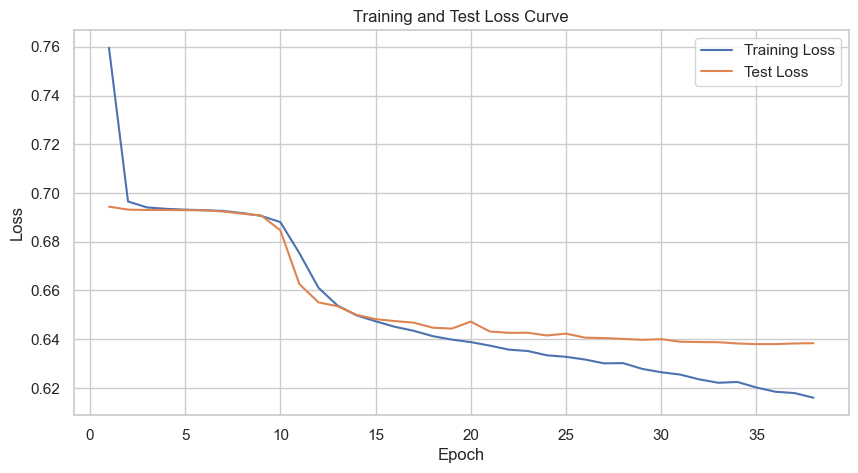

Loss curve saved as loss_curve.png


In [ ]:
import torch.nn as nn
from torchvision import models
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch

BATCH_SIZE = 32
EPOCHS = 50
LR = 1e-5
PATIENCE = 3  # Stop if no improvement after 2 epochs
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

output = os.path.join(MODEL_DIR, "squeeze_multilabel2.pth")

train_losses = []
test_losses = []

# Load and modify SqueezeNet
base_model = models.squeezenet1_1(pretrained=True)
base_model.classifier = nn.Sequential(
    nn.Dropout(p=0.5),
    nn.Conv2d(512, 6, kernel_size=1),
    nn.ReLU(inplace=True),
    nn.AdaptiveAvgPool2d((1, 1)),
    nn.Sigmoid()
)

class SqueezeNetWrapper(nn.Module):
    def __init__(self, base_model):
        super().__init__()
        self.base_model = base_model

    def forward(self, x):
        x = self.base_model(x)
        return x.view(x.size(0), -1)

model = SqueezeNetWrapper(base_model).to(DEVICE)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

best_loss = float('inf')
epochs_no_improve = 0
early_stop = False

for epoch in range(EPOCHS):
    if early_stop:
        print(f"Early stopping triggered at epoch {epoch}")
        break

    model.train()
    running_loss = 0.0
    for images, labels, _, _ in tqdm(train_loader):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

    epoch_train_loss = running_loss / len(train_dataset)
    train_losses.append(epoch_train_loss)

    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for images, labels, _, _ in small_test_loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)

    epoch_test_loss = test_loss / len(small_test_loader.dataset)
    test_losses.append(epoch_test_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")

    # Early stopping check
    if epoch_test_loss < best_loss:
        best_loss = epoch_test_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), output)
        print("Model improved and saved.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            early_stop = True

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()
plt.grid(True)
plt.savefig("loss_curve.png")
plt.show()

print("Loss curve saved as loss_curve.png")
